In [1]:
#Computing
from astropy.io import fits
import numpy as np
import math
import treecorr
import time
import random
#import pyccl as ccl
import gc

#for masks:
#import healpy as hp
#import h5py as h5
#import healsparse as hs


#for saving:
import pickle

#for ploting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display, Math

# data for test

In [2]:
# load the data photometric sample and the randoms:
fin = fits.open('/pscratch/sd/q/qhang/desi-lya/results/run-0/catalogue/unknown-zmin-1.8-zmax-3.0.fits')
ra = fin[1].data['RA']
dec = fin[1].data['DEC']
z = fin[1].data['Z']

fin = fits.open('/pscratch/sd/q/qhang/desi-lya/random-catalogue-overlap-w-z.fits')
ra_rand_use = fin[1].data['RA']
dec_rand_use = fin[1].data['DeC']

# the function 

In [3]:
def w_xx(sample_x, theta_range, z_range, Ntheta, Nz, Npatch, z_for_rand ,Eta_rand):
    '''
    Code to compute the auto-correlation of sample_x,
    -------------------------------------
    Outputs:
    Wz: is a Nz x Nalpha array, where Nz is the number of z bins, and Nalpha the number of scale weighting
    Thus Wz[iz][ialpha] is the value for wxx for the z-bin iz, and the scale weighting ialpha
    
    Err is a Nz x Nalpha uncertainty array associated to WZ.

    Multi_cov is the Nz x Njkk x Nalpha array usefull to compute the full covariance!!

    For std tests, use directly WZ and Err. Usually redshift covariance is negligible.
    -------------------------------------
    Inputs:
    sample_x: name of the sample, the only option now is sample_x='photo' and 'eBOSS ELG'
    
    theta_range is an array = [theta_min,theta_max], with theta IN ARCMIN !!!!
    z_for_rand is an array = [zmin,zmax]

    Ntheta is the number of theta-bins (default use 10)
    Nz is the number of z-bins
    Npatch the number of Jkk patches to evaluate the cov
    
    z_for_rand==True means there are redshifts for randoms
    Eta_rand is how many more randoms you want, to evaluate the DD/RR counts
    -------------------------------------
    '''
    print('evaluate the auto-corr of ', sample_x)
    print('for',z_range[0], '<z<',z_range[1],'  with ', Nz, ' bins')

    zmin=z_range[0]
    zmax=z_range[1]
    dz=(zmax-zmin)/Nz
    theta_min=theta_range[0]/60 # arcmin to degree
    theta_max=theta_range[1]/60 # arcmin to degree
    
    # You can add other options, with another elif, eg with sample_x=='spec'
    if sample_x=='photo':
        ra_gal =ra
        dec_gal =dec
        z_gal = z
        w_gal = np.array([1 for i in ra_gal]) #if you do have weights, replace this array
        
        ra_rand = ra_rand_use
        dec_rand = dec_rand_use
        w_rand =  np.array([1 for i in ra_rand])
        if z_for_rand==True:
            z_rand=z_rand_use
    elif sample_x=='eBOSS ELG':
        ra_gal =ra_eboss_ELG_south
        dec_gal =dec_eboss_ELG_south
        z_gal =z_eboss_ELG_south
        w_gal =  weight_eboss_ELG_south#np.array([1 for i in ra_gal]) #if you do have weights, replace this array
        
        ra_rand =ra_rand_eboss_ELG_south
        dec_rand =dec_rand_eboss_ELG_south
        w_rand =  weight_rand_eboss_ELG_south
        if z_for_rand==True:
            z_rand=z_rand_eboss_ELG_south
    else:
        print('sample_x not included in the code')

    print(len(ra_gal) ,' galaxies ')
    print(len(ra_rand) ,'randoms ')

    
    Wz=[]
    Cov=[]
    Err=[]
    Multi_cov=[]
    
    #create a catalog to have the Jkk patches
    cat_patch = treecorr.Catalog(ra=ra_gal,dec=dec_gal,w=w_gal,ra_units='degrees',dec_units='degrees',npatch=Npatch)

    for iz in range(Nz):
        zmean_i=zmin+(iz+0.5)*dz
        zmin_i=zmin+(iz)*dz
        zmax_i=zmin+(iz+1)*dz

        print('zi=',round(zmean_i,3),' dz=',round(dz,3))
        
        sel_gal_subbin=((z_gal>=zmin_i)&(z_gal<zmax_i))
        cat_gal_subbin=treecorr.Catalog(ra=ra_gal[sel_gal_subbin],dec=dec_gal[sel_gal_subbin],w=w_gal[sel_gal_subbin],ra_units='degrees',dec_units='degrees',patch_centers=cat_patch.patch_centers)
        

        # Do we have z for randoms: 
        if z_for_rand==True:
            sel_rand_subbin=((z_rand>=zmin_i)&(z_rand<zmax_i))
        else:
            sel_rand_subbin=np.array([True for r in ra_rand])
        # Select Eta_rand more randoms than gal
        Ntot=len(ra_rand[sel_rand_subbin])
        Nrand=Eta_rand*len(ra_gal[sel_gal_subbin])
        Index=random.choices(range(Ntot), k=Nrand)
        
        
        ra_rand_select=ra_rand[sel_rand_subbin][Index]
        dec_rand_select=dec_rand[sel_rand_subbin][Index]
        w_rand_select=w_rand[sel_rand_subbin][Index]
    
        cat_rand_subbin=treecorr.Catalog(ra=ra_rand_select,dec=dec_rand_select,w=w_rand_select,ra_units='degrees',dec_units='degrees', patch_centers=cat_patch.patch_centers)
    
        wxx  = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)
        rrxx = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)
        drxx = treecorr.NNCorrelation(min_sep=theta_min,max_sep=theta_max,nbins=Ntheta,var_method='jackknife',sep_units='degree',bin_slop=0.01)

        #Now I use r as a name instead of theta
        rlist=wxx.rnom
        redges=wxx.right_edges-wxx.left_edges
        #print(rlist)
        #print(redges)
        def integ_wxx(w1):
            '''
            integrate w1 over theta, with different scales weighting, defined by List_alpha:
            W(theta)=theta**alpha/norm
            '''
            List_alpha=[-1,0,1]
            Results_alpha=[]
            Noweight=w1
            for alpha in  List_alpha:
                w1b=0
                norm=0
                for ir in range(len(w1)):
                    w1b+=w1[ir]*rlist[ir]**alpha*redges[ir]
                    norm+=rlist[ir]**alpha*redges[ir]
                Results_alpha.append(w1b/norm)

            return np.array(Results_alpha)
            
            
        rrxx.process(cat_rand_subbin,cat_rand_subbin)
        drxx.process(cat_rand_subbin,cat_gal_subbin)
        
        wxx.process(cat_gal_subbin,cat_gal_subbin)
        wxx.calculateXi(rr=rrxx,dr=drxx)
         
        my_funct = lambda corrs: integ_wxx(corrs[0].xi)
        corrs = [wxx]
            
        ratio = my_funct(corrs)  
        cov = treecorr.estimate_multi_cov(corrs, 'jackknife', func=my_funct)
        multi_cov=treecorr.build_multi_cov_design_matrix(corrs,'jackknife', func=my_funct, comm=None)
        
        Wz.append(ratio)
        Cov.append(cov)
        Err.append([np.sqrt(cov[i][i]) for i in range(np.size(cov,0))])
        Multi_cov.append(multi_cov[0])
        
        del(cat_gal_subbin)
        del(cat_rand_subbin)
        gc.collect()
    return(Wz,Err,Multi_cov)

    

# Plots

In [4]:
A0,B0,C0=w_xx(sample_x='photo', theta_range=[10,30], z_range=[2,3], Ntheta=1, Nz=20, Npatch=64, z_for_rand=False ,Eta_rand=5)

evaluate the auto-corr of  photo
for 2 <z< 3   with  20  bins
110938487  galaxies 
169985370 randoms 
zi= 2.025  dz= 0.05
zi= 2.075  dz= 0.05
zi= 2.125  dz= 0.05
zi= 2.175  dz= 0.05
zi= 2.225  dz= 0.05
zi= 2.275  dz= 0.05
zi= 2.325  dz= 0.05
zi= 2.375  dz= 0.05
zi= 2.425  dz= 0.05
zi= 2.475  dz= 0.05
zi= 2.525  dz= 0.05
zi= 2.575  dz= 0.05
zi= 2.625  dz= 0.05
zi= 2.675  dz= 0.05
zi= 2.725  dz= 0.05
zi= 2.775  dz= 0.05
zi= 2.825  dz= 0.05
zi= 2.875  dz= 0.05
zi= 2.925  dz= 0.05
zi= 2.975  dz= 0.05


In [8]:
# let's also measure 40 bins:
A1,B1,C1=w_xx(sample_x='photo', theta_range=[10,30], z_range=[2,3], Ntheta=1, Nz=40, Npatch=64, z_for_rand=False ,Eta_rand=5)

evaluate the auto-corr of  photo
for 2 <z< 3   with  40  bins
110938487  galaxies 
169985370 randoms 
zi= 2.013  dz= 0.025
zi= 2.038  dz= 0.025
zi= 2.062  dz= 0.025
zi= 2.087  dz= 0.025
zi= 2.112  dz= 0.025
zi= 2.138  dz= 0.025
zi= 2.163  dz= 0.025
zi= 2.188  dz= 0.025
zi= 2.212  dz= 0.025
zi= 2.237  dz= 0.025
zi= 2.263  dz= 0.025
zi= 2.288  dz= 0.025
zi= 2.312  dz= 0.025
zi= 2.337  dz= 0.025
zi= 2.362  dz= 0.025
zi= 2.388  dz= 0.025
zi= 2.413  dz= 0.025
zi= 2.438  dz= 0.025
zi= 2.462  dz= 0.025
zi= 2.487  dz= 0.025
zi= 2.513  dz= 0.025
zi= 2.538  dz= 0.025
zi= 2.562  dz= 0.025
zi= 2.587  dz= 0.025
zi= 2.612  dz= 0.025
zi= 2.638  dz= 0.025
zi= 2.663  dz= 0.025
zi= 2.688  dz= 0.025
zi= 2.712  dz= 0.025
zi= 2.737  dz= 0.025
zi= 2.763  dz= 0.025
zi= 2.788  dz= 0.025
zi= 2.812  dz= 0.025
zi= 2.837  dz= 0.025
zi= 2.862  dz= 0.025
zi= 2.888  dz= 0.025
zi= 2.913  dz= 0.025
zi= 2.938  dz= 0.025
zi= 2.962  dz= 0.025
zi= 2.987  dz= 0.025
The following patch numbers have no objects: {0, 1, 3, 9, 

In [20]:
# load yaw measurements:
yaw_20bin = np.loadtxt("mock0-wpp-20bins-baseline.txt")
yaw_40bin = np.loadtxt("mock0-wpp-40bins-baseline.txt")

(0.0, 0.3)

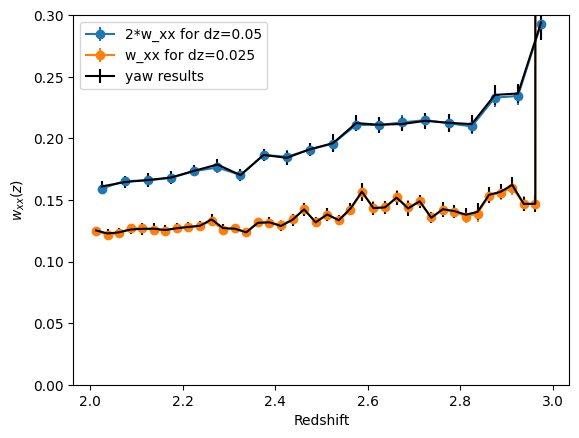

In [25]:
ialpha=1
plt.xlabel('Redshift')
plt.ylabel(r'$w_{xx}(z)$')
plt.errorbar([2.025+0.05*i for i in range(20)], [2*A0[i][ialpha] for i in range(20)],yerr=[2*B0[i][ialpha] for i in range(20)],marker='o',label='2*w_xx for dz=0.05')
plt.errorbar([2.0125+0.025*i for i in range(40)], [A1[i][ialpha] for i in range(40)],yerr=[B1[i][ialpha] for i in range(40)],marker='o',label='w_xx for dz=0.025')

# yaw:
plt.errorbar(yaw_40bin[:,0], yaw_40bin[:,1], yerr=yaw_40bin[:,2],color='k')
plt.errorbar(yaw_20bin[:,0], yaw_20bin[:,1]*2, yerr=yaw_20bin[:,2]*2,color='k',label="yaw results")

plt.legend()
plt.ylim([0,0.3])

In [17]:
# save the results:
np.savetxt("wpp-baseline-20bin-williams-code.txt", np.c_[np.array([2.025+0.05*i for i in range(20)]),
           np.array([A0[i][ialpha] for i in range(20)]),np.array([B0[i][ialpha] for i in range(20)])])

In [19]:
# save the results:
np.savetxt("wpp-baseline-40bin-williams-code.txt", np.c_[np.array([2.0125+0.025*i for i in range(40)]),
           np.array([A1[i][ialpha] for i in range(40)]),np.array([B1[i][ialpha] for i in range(40)])])

### this is how to compute the redshift-covariance matrix from multi_cov returned by the cov....

In [106]:
Nz=8
Nalpha=3
Njkk=100

C_mat=C1
w_wz1=[]
Cov_wz1=[]
Err_wz1=[]
for ialpha in range(Nalpha):
    D0=np.array([[C_mat[iz][jk][ialpha] for jk in range(Njkk)]for iz in range(Nz)],dtype=np.float64)

    w_wz1.append(np.array([1/Njkk*np.sum(D0[jz]) for jz in range(Nz)],np.float64))
    Cov_wz1.append(np.array([[ ( Njkk-1)/Njkk* np.sum((D0[imat] - w_wz1[ialpha][imat]) * (D0[jmat] - w_wz1[ialpha][jmat])) for jmat in range(Nz)] for imat in range(Nz)],np.float64))    
    Err_wz1.append([np.sqrt(Cov_wz1[ialpha][i][i]) for i in range(Nz)])
    

In [107]:
#first dim in Nalpha, then Nz
print(np.shape(w_wz1))
print(np.shape(Cov_wz1))

(3, 8)
(3, 8, 8)
